# Deep Neural Network for classification

### Objective:

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [961]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras import optimizers

## Loading the dataset

In [5]:
path='/Users/user/Downloads/bank.csv'


In [1319]:
df=pd.read_csv(path)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Exploratory data analysis

In [4]:
df.shape

(10000, 14)

apparently there are 10000 observations(customers), and 14 columns, containing the features for each customer

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


So, null values appear to be absent from the dataset. This does not necessarily mean that all values are legitimate and they will need to be examined more accurately

In [7]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

There are 10000 customers, by ID, but there are only 2932 unique surnames. These are most likely homonimous and will be left like that. However, we will not probably need Rownumbers, Customer IDs and Surnames for our analysis

In [1320]:
df=df.drop(['RowNumber','CustomerId','Surname'], axis=1)
#we can then proceed and remove them from the dataset

## Univariate analysis

In [9]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


We should now proceed to analysis the above features:
- Credit Score: Credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.In our dataset, the mean credit score is 650, which s very close to the median (652), with a standard deviation of 96.65, ranging from a minimum of 350 to a maximum of 850. If we consider the 1st quartile (584, the value below which we find 25% of the customers in the dataset), we can probably anticipate a quasi-normal distribution.

- Age: Age of the customer. Age ranges (not surprisingly) from 18 y/o to 92. The 25% quartile is 32, while the 3rd quartile is 44, which indicates a slight right skew and a long right tail of a few exceptionally old customers.

- Tenure: The period of time (presumably indicated in years) a customer has been associated with the bank, ranging from 0 to 10 years. The mean (and median) is about 5, with a standard deviation of 2.89. The 25% quartile is 3 and the 75% is 7 years.

- Balance: The account balance (the amount of money deposited in the bank account) of the customer. These customers have an average of 76485 USD, with a SD of 62000 USD. However the 25% percentile is 0, which means that a big chunk of these customers (about 2500 customers) has a 0 balance. This might also mean that there are some missing data, however it does not seem unplausible that customers have no money on their accounts, and it will be accepted as such for the analysis.

- NumOfProducts: How many accounts, bank account affiliated products the person has. The range is from 1 (of course no customers has 0 products, or they would not be part of the dataset) to 4. The mean value is 1.53, and the 25% percentile is 1, meaning that 25% of the customers has 1 or less products. 1 is also the median, while the 75% percentile is 2, i.e. 75% of the customers has 2 or fewer products.

- HasCrCard: Does the customer have a credit card through the bank? A binary variable, 25% percentile is 0, which indicates that 25% of the customers do not own a credit card, while 75% do.

- IsActiveMember: This variable indicates whether the customer is an active member. It is a binary variable and while 25% of the custmers is not an active member, 75% are, based on the distribution of quartiles.

- EstimatedSalary: Estimated salary of the customer. The salary ranges from about 11 to 199000 USD. The mean (and median) salary is about 100k, with a 25% percentile of 51000, and a 75% percentile of 150k

- Exited: Did they leave the bank after all? This is a binary variable, with 1 indicating that the customer  left the bank and 0 that the customer did not. 75% of the customers (3rd quartile) did not leave the bank.

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


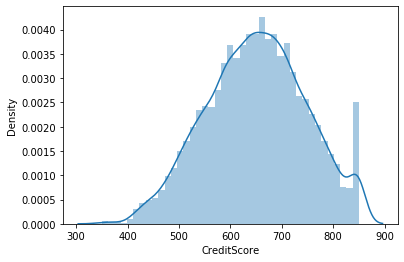

In [279]:
sns.distplot(df.CreditScore)

As predicted the distribution for Credit score is almost normal, slightly left skewed.

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


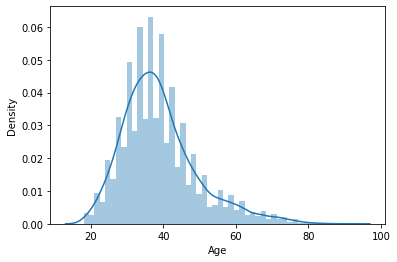

In [277]:
sns.distplot(df.Age)

The distribution for age is slightly right skewed

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


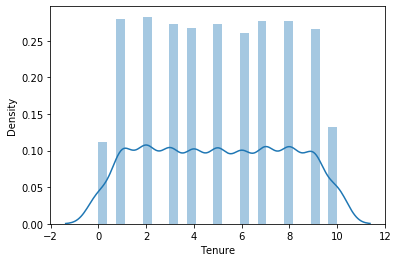

In [280]:
sns.distplot(df.Tenure)

Tenure is quite homogeneously distributed, and different tenures are quite equally represented

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


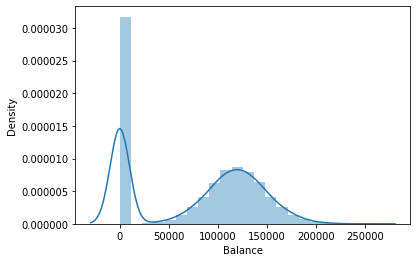

In [1321]:
sns.distplot(df.Balance)

As we previously gauged it from the data description, the balance comprises a big chunk of customers that has 0 balance, while those who have some money on the account are distributed normally.

In [296]:
df['Balance'].loc[df.Balance==0].count()

3617

Actually 3617 customers have 0 balance!

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


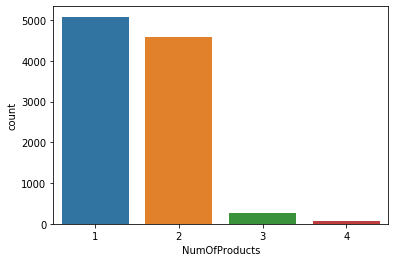

In [14]:
sns.countplot(df.NumOfProducts)

For the number of products I chose to use a countplot. The vast majority of our customers have 1 or 2 products, with a maximum of 4 products

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


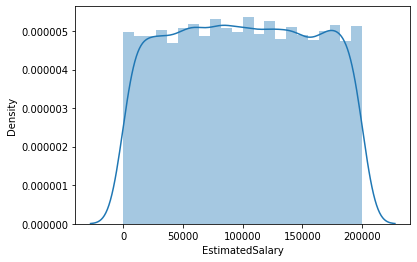

In [283]:
sns.distplot(df.EstimatedSalary)

Salaries appear quite homogeneously distributed across the whole spectrum, from 11k to 199k USD

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


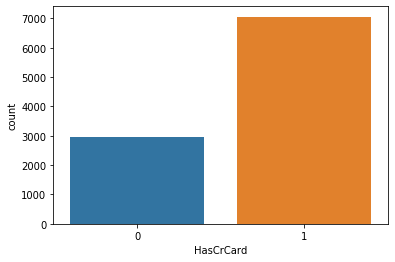

In [15]:
sns.countplot(df.HasCrCard)

The majority of our customers have a credit card, only about 1/3 of them does not

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


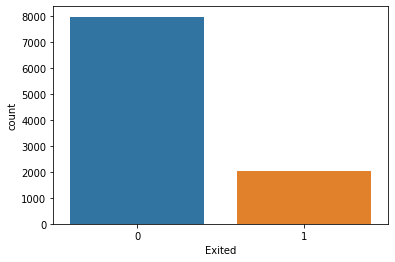

In [13]:
sns.countplot(df.Exited)

The majority of customers have NOT exited the bank, those who left amount to approximately 20%

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


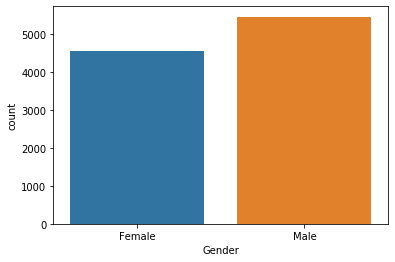

In [28]:
sns.countplot(df.Gender)

Both sexes are almost equally repesented in the dataset, with a slight majority of males.

/Users/user/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


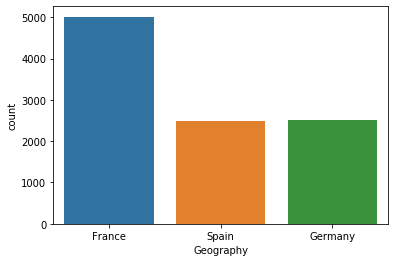

In [29]:
sns.countplot(df.Geography)

Our dataset comprises customers from 3 nations, namely France, Spain and Germany. These last 2 features will have to be converted to one hot encoding 

In [1322]:
df= pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
#I used panda's get_dummies function to convert the categorical features

In [1323]:
df=df.astype(float)

# Bivariate analysis

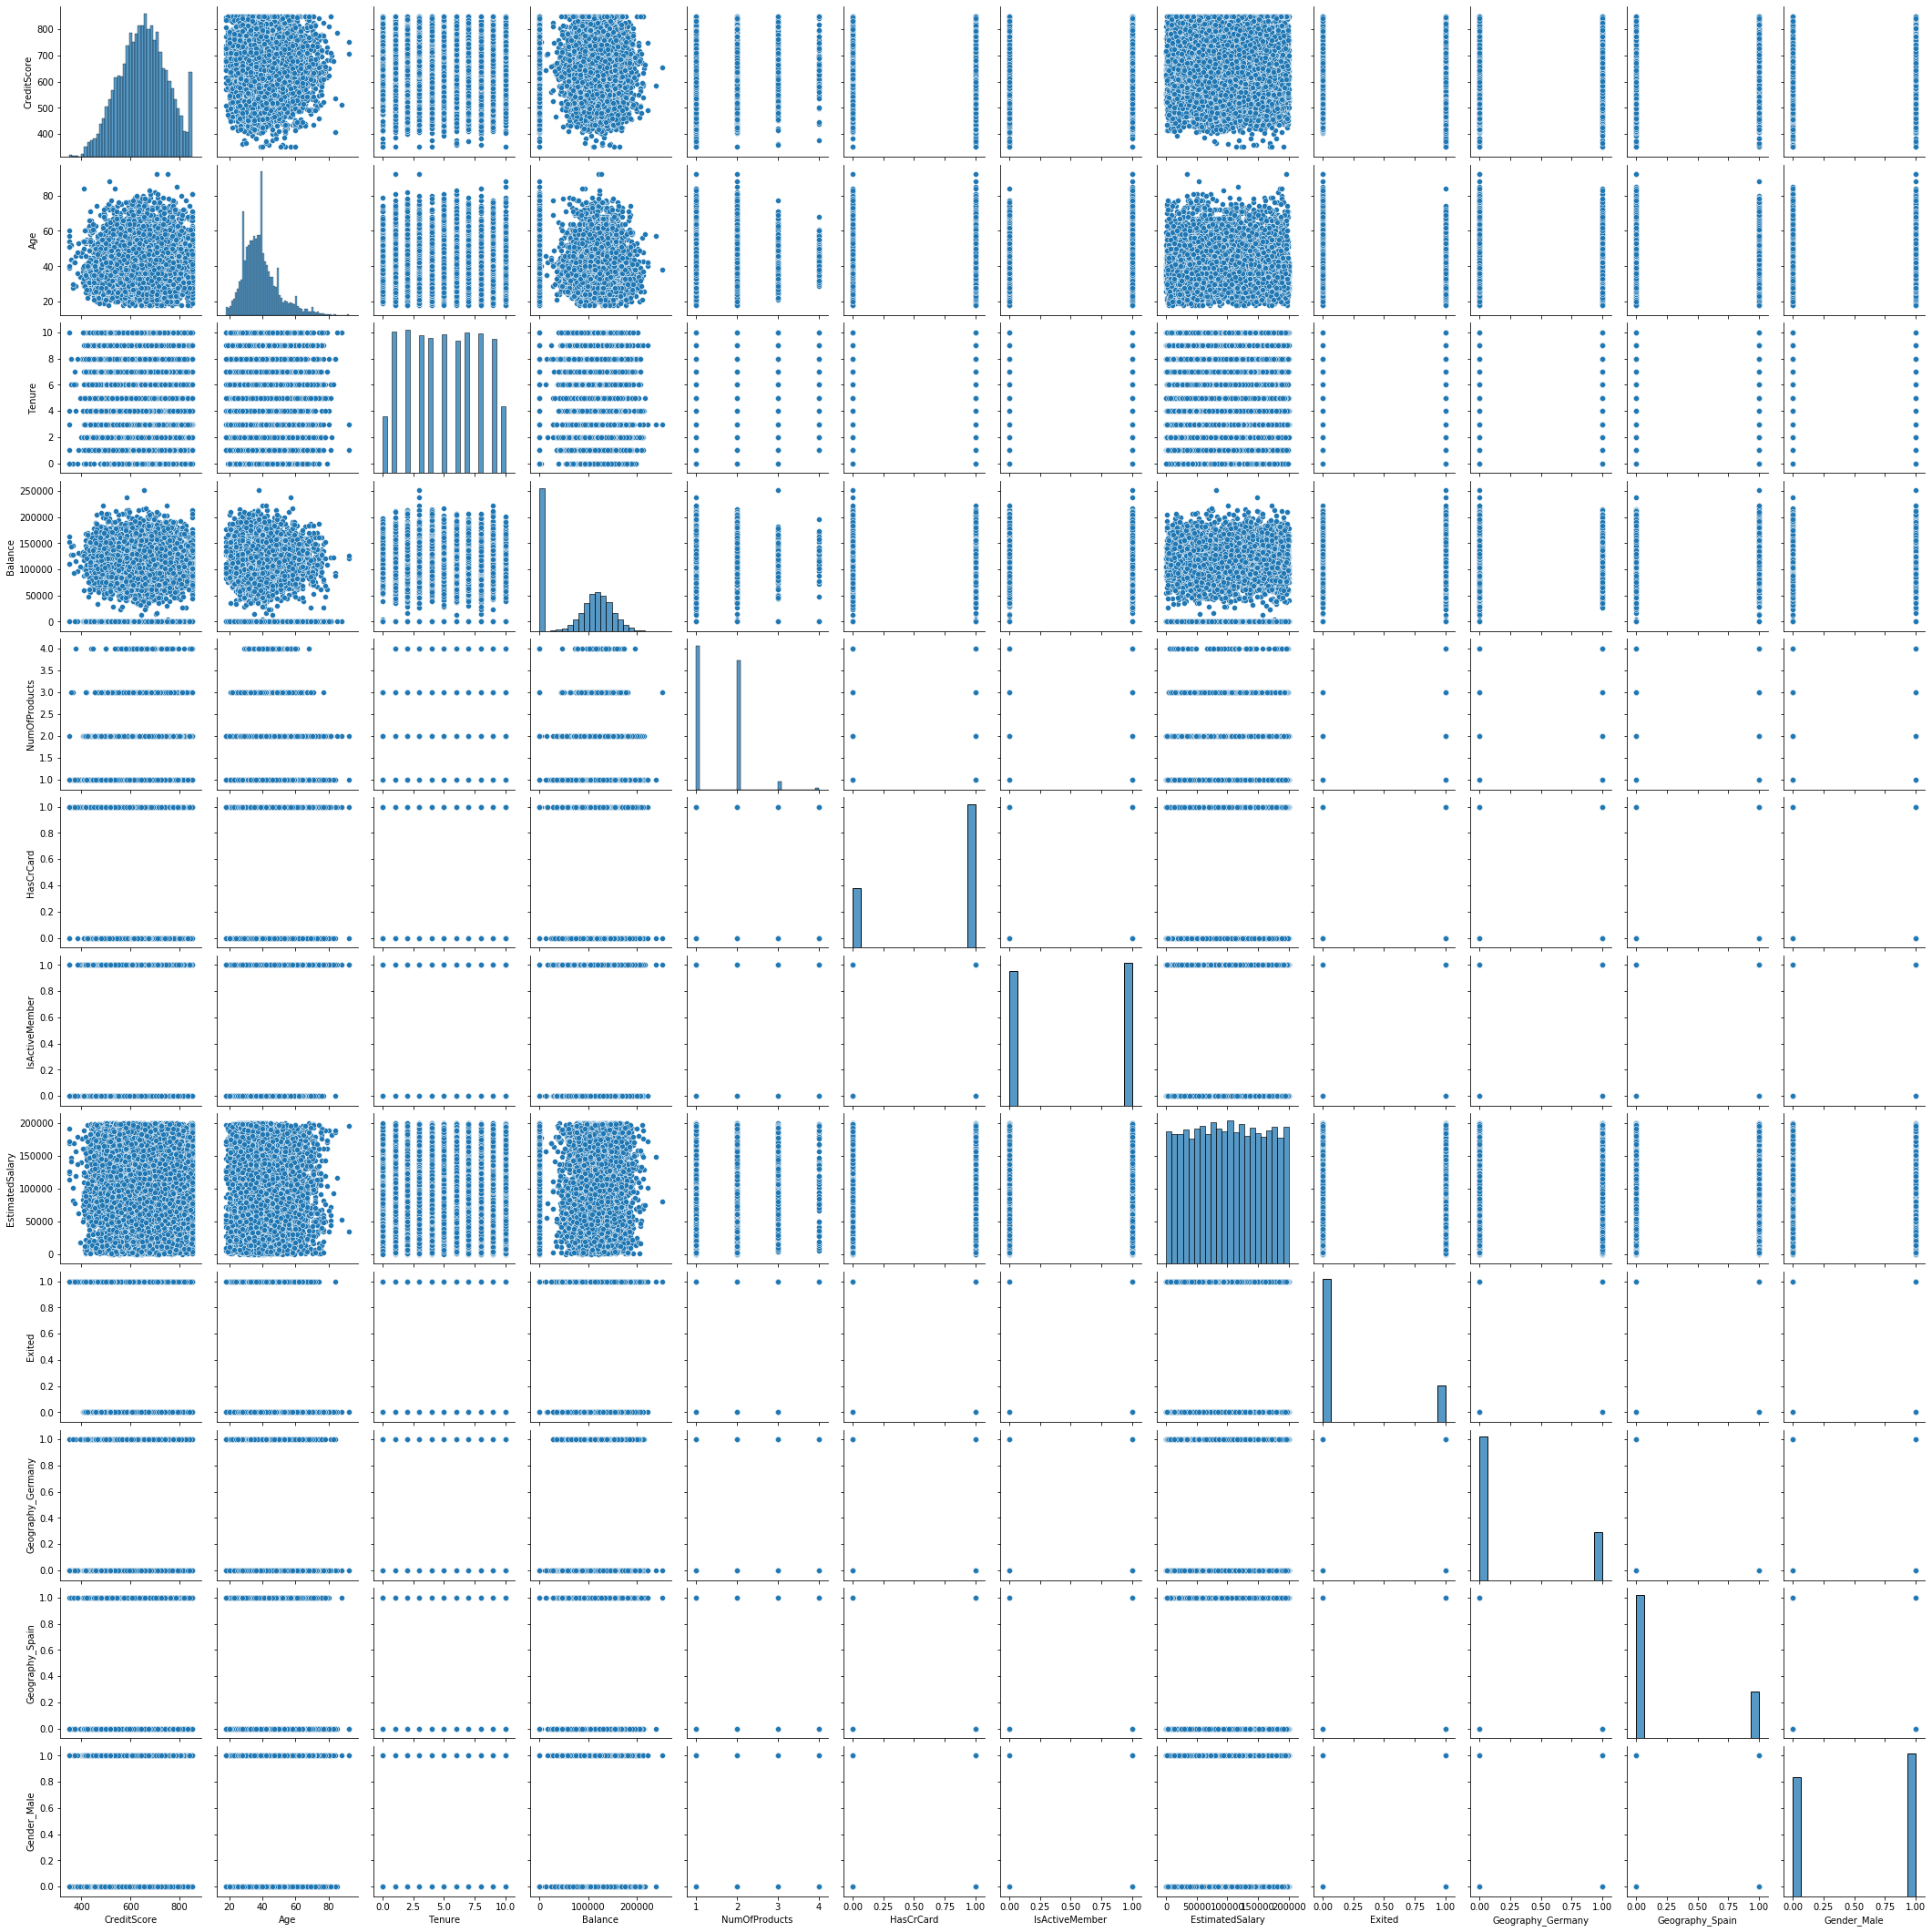

In [35]:
sns.pairplot(df)

No clear association between features is visible at pairplots

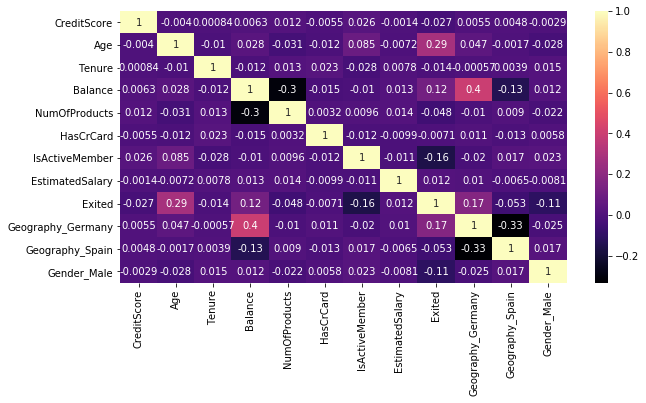

In [36]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap='magma')

The above figure is the correlation matrix of our variables, expressed as a heatmap. The number in every cell is the correlation coefficient, or Person's R. From this graph, it appears that, overall, the features are scarcely correlated, i.e. independent.
There appears to be some slight positive association between being german and balance, and, at a lower level age and exit. A r=0.17 positive correlation between being german and exit also exists. A negative correlation of some sorts might exist between balance and number of products. Overall, the correlation indices are low,all equal or below 0.4. 
All features are therefore kept for analysis.


## Data pre-processing

Data  first have to be scaled. To this purpose I used Standardscaler

In [1005]:
scaler=StandardScaler()

In [1324]:
df[['CreditScore','Age','Tenure','Balance', 'EstimatedSalary']]=scaler.fit_transform(df[['CreditScore','Age','Tenure','Balance', 'EstimatedSalary']])


In [1325]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,1.0,1.0,1.0,0.021886,1.0,0.0,0.0,0.0
1,-0.440036,0.198164,-1.387538,0.117350,1.0,0.0,1.0,0.216534,0.0,0.0,1.0,0.0
2,-1.536794,0.293517,1.032908,1.333053,3.0,1.0,0.0,0.240687,1.0,0.0,0.0,0.0
3,0.501521,0.007457,-1.387538,-1.225848,2.0,0.0,0.0,-0.108918,0.0,0.0,0.0,0.0
4,2.063884,0.388871,-1.041760,0.785728,1.0,1.0,1.0,-0.365276,0.0,0.0,1.0,0.0


In [34]:
df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [1326]:
y=df['Exited']
X=df.drop('Exited', axis=1)

Now I have created the target feature y, Exited, and all other columns are in the X feature dataset

In [1327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)
#This function creates train and test datasets

# ANN

In [2173]:
model= keras.models.Sequential()
#let's first create the model

In [2174]:
model.add(keras.layers.Dense(11, input_shape = (11,), activation='relu'))
model.add(keras.layers.Dense(11, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

#adding layers with activation functions

In [2175]:
sgd = optimizers.RMSprop(lr = 0.01)
#setting the learning rate and the optimization method

In [2176]:
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
#the model need to be compiled, and some hyperparameters are set

In [2177]:
model.summary()
#this is the summary of the network structure


Model: "sequential_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1289 (Dense)           (None, 11)                132       
_________________________________________________________________
dense_1290 (Dense)           (None, 11)                132       
_________________________________________________________________
dense_1291 (Dense)           (None, 1)                 12        
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________


In [2178]:
model.fit(X_train, y_train.values, batch_size = 100, epochs = 10, verbose = 1)
#First, the network is trained with the train sets over 100 epochs. 

Epoch 1/10
70/70 [==============================] - 0s 821us/step - loss: 0.5074 - accuracy: 0.7705
Epoch 2/10
70/70 [==============================] - 0s 824us/step - loss: 0.4345 - accuracy: 0.8099
Epoch 3/10
70/70 [==============================] - 0s 785us/step - loss: 0.4063 - accuracy: 0.8262
Epoch 4/10
70/70 [==============================] - 0s 785us/step - loss: 0.3920 - accuracy: 0.8381
Epoch 5/10
70/70 [==============================] - 0s 774us/step - loss: 0.3708 - accuracy: 0.8453
Epoch 6/10
70/70 [==============================] - 0s 778us/step - loss: 0.3559 - accuracy: 0.8587
Epoch 7/10
70/70 [==============================] - 0s 772us/step - loss: 0.3508 - accuracy: 0.8559
Epoch 8/10
70/70 [==============================] - 0s 756us/step - loss: 0.3341 - accuracy: 0.8646
Epoch 9/10
70/70 [==============================] - 0s 789us/step - loss: 0.3428 - accuracy: 0.8583
Epoch 10/10
70/70 [==============================] - 0s 783us/step - loss: 0.3290 - accuracy: 0.8685

With only 10 epochs, an accuracy of 86% on the training set is achieved

In [2186]:
X_test = preprocessing.normalize(X_test)
results = model.evaluate(X_test, y_test.values)
print(model.metrics_names)
print(results)    


94/94 [==============================] - 0s 646us/step - loss: 0.6309 - accuracy: 0.7110
['loss', 'accuracy']
[0.6309247016906738, 0.7110000252723694]


Accuracy is quite high with the test set too

In [2181]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))
confusion_matrix(y_test.values, Y_pred_cls)

94/94 [==============================] - 0s 635us/step - loss: 0.6309 - accuracy: 0.7110
Accuracy Model1 (Dropout): 0.7110000252723694
Recall_score: 0.6586921850079744
Precision_score: 0.3874296435272045
F-score: 0.4878913171884228


/Users/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1720,  653],
       [ 214,  413]])

The metrics for this classification task are mediocre, with an accuracy of 71%% (71% of the customers have been correctly identified), 38% precision(true positive over the total number of predicted positive) and a recall (true positive over real positive, i.el. true positives + false negatives) of 65%. The F1 score, which the harmonic mean of precision and recall is 48%

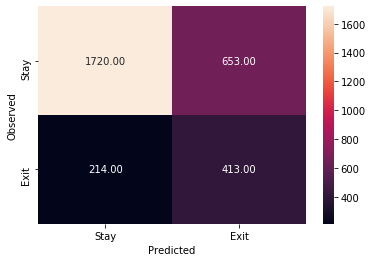

In [2187]:
cm = confusion_matrix(y_test.values, Y_pred_cls)
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ['Stay', 'Exit'] , yticklabels = ['Stay', 'Exit'] )
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.show()

I graphically plotted the confusion matrix to get a better look at it. The trained neural network is capable to predict whether a customer will exit the bank, with high precision and recall.

## Conclusions

The adopted model appears quite effective in predicting customers who are goig to exit based on the features provided by the database. Such algorithm, trained on a substantially large set of training data could be then used as a screening method to highlight potential customers that are more likely to abandon the bank. One of the drawbacks of this approach is that the method is somewhat of a black box, and it is difficult to get insights into the customers and how their characteristics affect the outcome